#Prediction EAQI with different classifier

In [1]:
###############################################
###                Imports                  ###
###############################################
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image


df = pd.read_csv('../processed_data/full_data_imputed_with_EAQI.csv')
df = df.dropna()

In [2]:
#################################################
### General Settings: (Activate / Deactivate) ###
#################################################

# LINEAR MODELS
#   - 1. Support Vector Machines (SVM)
support_vector_machines = False

# NON-LINEAR MODELS
#   - 1. Decision Tree
decision_tree = True
#   - 2. K-Nearest-Neighbor (Knn)
knn = True
#   - 3. Random Forest
random_forest = True

In [3]:
###############################################
### split dataset into a train and test set ###
###############################################

X = df[['T', 'StrGlo', 'Jahr', 'Monat', 'Tag', 'Zweirad', 'Personenwagen', 'Lastwagen', 'Hr', 'RainDur', 'WVs',
        'p']]  # leave out NO2, PM10_calc,NO2_AQI,PM10_AQI, PM10 and AQI
y = df[["AQI"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
###############################################
###    reduce sample number for functions   ###
###############################################
n = -1 # number of samples (-1 = all samples)
if n == -1:
    pass
elif n== 0:
    raise ValueError
else:
    X_train = X_train[1:n]
    X_test = X_test[1:n]
    y_train = y_train[1:n]
    y_test = y_test[1:n]

In [5]:
###############################################
###         Save string to textfile         ###
###############################################

def save(string, n):
    doc = "results_classification_eqi.txt"

    with open(doc, "a+") as f:
        f.write(string)
        for i in range(n):
            f.write('\n')
        f.close()


In [6]:
###############################################
###            LINEAR MODELS                ###
###############################################

###############################################
###     1. Support Vector Machines (SVM)    ###
###############################################
if support_vector_machines == True:
    from sklearn.metrics import accuracy_score

    params = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }

    clf = GridSearchCV(
        estimator=SVC(),
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_score_, clf.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7830279767483905 {'criterion': 'entropy', 'max_depth': 70, 'splitter': 'random'}


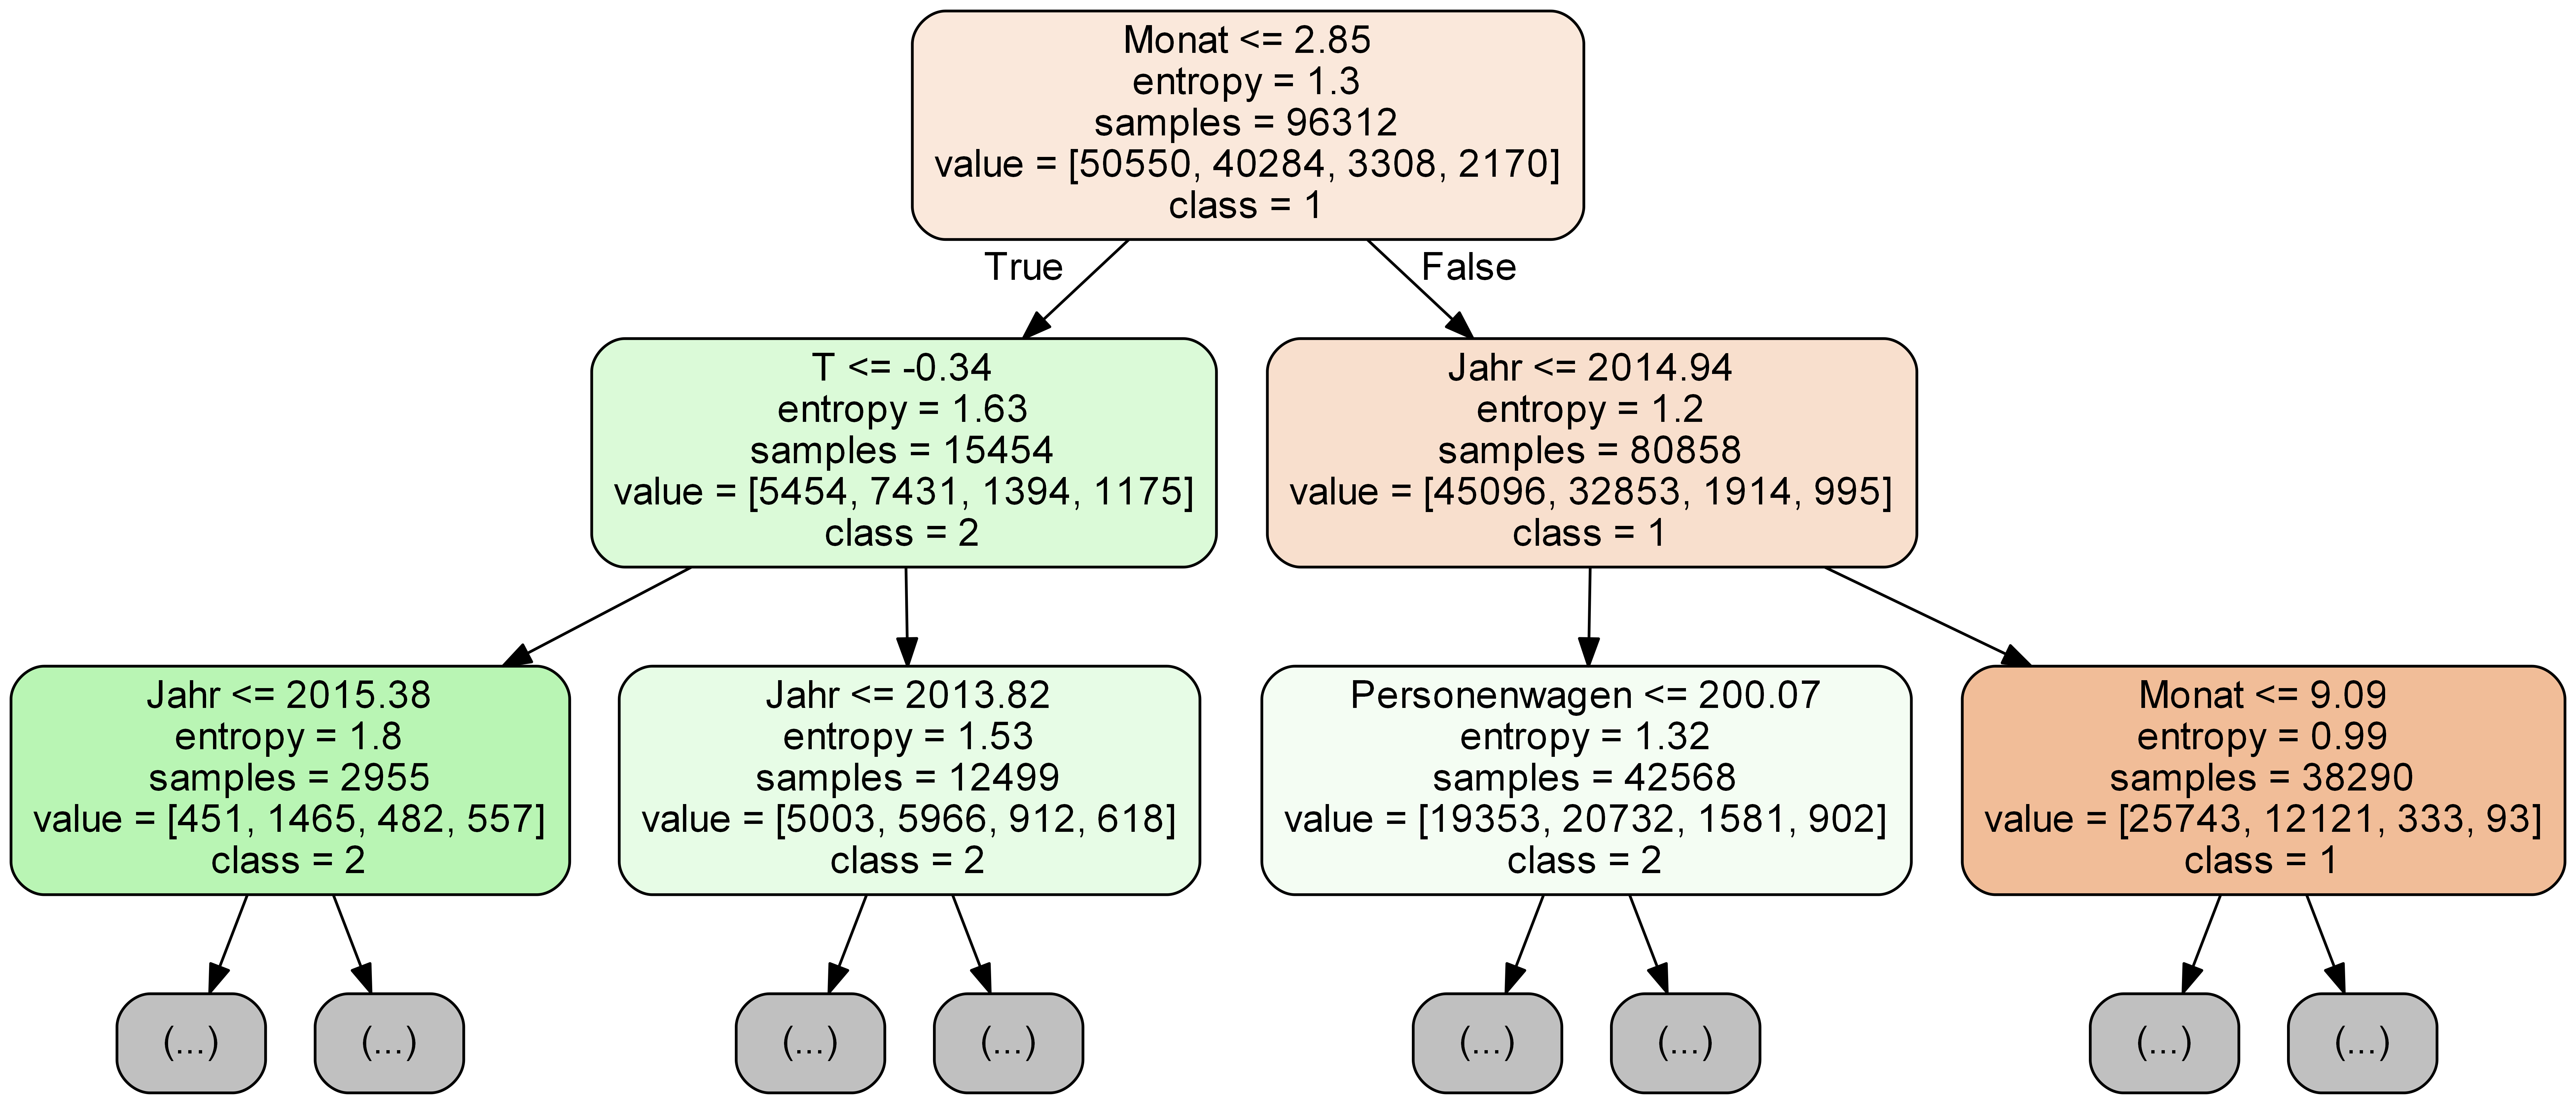

In [13]:
###############################################
###          NON LINEAR MODELS              ###
###############################################

###############################################
###          1. Decision Tree               ###
###############################################
if decision_tree == True:
    params = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [50, 60,70],
        # 'min_samples_leaf' : range(1,10,1),
        # 'min_samples_split': range(2,10,1),
        'splitter': ['best', 'random']
    }
    clf = GridSearchCV(
        estimator=tree.DecisionTreeClassifier(),
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='accuracy'
    )

    clf.fit(X_train, y_train.values.ravel())
    tree_model = clf.best_estimator_
    print(clf.best_score_, clf.best_params_)
    # Plot entire Tree
    export_graphviz(tree_model,
                    out_file='tree.dot',
                    feature_names = ['T', 'StrGlo', 'Jahr', 'Monat', 'Tag', 'Zweirad', 'Personenwagen', 'Lastwagen', 'Hr',
                                  'RainDur', 'WVs', 'p'],
                    class_names = ['1', '2' , '3', '4','5'],
                    rounded = True, 
                    proportion = False, 
                    precision = 2,
                    filled=True,
                    max_depth = 2) #to visualize only top x depth / default = None

!dot -Tpng tree.dot -o tree.png -Gdpi=600
Image(filename = 'tree.png')

In [8]:
###############################################
###             2. Knn with CV              ###
###############################################
if knn == True:
    knn = KNeighborsClassifier()
    params = [{'n_neighbors': [40, 100],
               'weights': ['uniform', 'distance'],
               'leaf_size': [15, 20]}]

    cv_knn = GridSearchCV(knn,
                          param_grid=params,
                          scoring='accuracy',
                          cv=5)

    cv_knn.fit(X_train, y_train.values.ravel())
    print(cv_knn.best_score_, cv_knn.best_params_)

0.6488703442012601 {'leaf_size': 15, 'n_neighbors': 40, 'weights': 'distance'}


0.8317032319080859 {'max_depth': 80, 'n_estimators': 200, 'n_jobs': -1}
^C


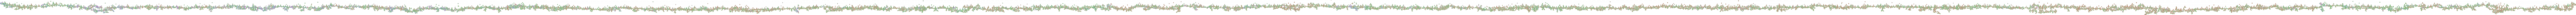

In [12]:
###############################################
###       3. Random Forest with CV          ###
###############################################

if random_forest == True:
    rfc = RandomForestClassifier()
    params = [{'n_estimators': [100, 200],
               'n_jobs': [-1],
               'max_depth': [40, 60, 80]}, ]

    cv_rfc = GridSearchCV(rfc,
                          param_grid=params,
                          scoring='accuracy',
                          cv=5)

    cv_rfc.fit(X_train, y_train.values.ravel())
    print(cv_rfc.best_score_, cv_rfc.best_params_)
    
    random_forest_model = cv_rfc.best_estimator_[0]

    # Plot Tree 1 of Random Forest
    export_graphviz(random_forest_model,
                    out_file='tree_rf.dot',
                    feature_names = ['T', 'StrGlo', 'Jahr', 'Monat', 'Tag', 'Zweirad', 'Personenwagen', 'Lastwagen', 'Hr',
                                  'RainDur', 'WVs', 'p'], 
                    class_names = ['1', '2' , '3', '4','5'],
                    rounded = True, 
                    proportion = False, 
                    precision = 2,
                    filled=True,
                    max_depth = 30) #to visualize only top x depth / default = None

!dot -Tpng tree_rf.dot -o tree_rf.png -Gdpi=600
Image(filename = 'tree_rf.png')